<a href="https://colab.research.google.com/github/HasanF19/YZM308_FINAL_PROJECT/blob/main/v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hasan ***Atakan*** Öztürk 220212002

Üretken Yapay Zeka YZM308 Final Projesi Türkçe şarkı sözü Üretimi


#Proje Temeli GenAi kısmı

##1)Kurulum ve import

In [8]:
!pip install --quiet sentencepiece tensorflow pandas openpyxl


In [9]:
import pandas as pd, sentencepiece as spm, tensorflow as tf, numpy as np, os, io, textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential
from IPython.display import Image as ColabImage, display
from PIL import Image, ImageDraw, ImageFont

##2)Dataset Tanıtım

In [10]:
#Öncelikle sizlere datasetimi tanıtmak istiyorum csv formatındaki bu dosyanın düzenlenmiş hali kullanılmaktadır
# *yüklüyoruz*
data = pd.read_csv("/content/drive/MyDrive/Python/son_hali_artik.csv")
data.head()

,sarkici,sarkisi,album,sozler
0,Ahmet Kaya,"(Potbori) Fabrika Kızı, Cama Çıkma, Fabrika Önü",Şafak Türküsü,Bir mavi otobüs gelirdi\nSeni alır giderdi\nO ...
1,Ahmet Kaya,Acı Ninni,Baş Kaldırıyorum,"Uyusun ha iyi büyüsün,\nCamlar buğulanmasın\nS..."
2,Ahmet Kaya,Acılara Tutunmak,Acılara Tutunmak,Kavuşmak özgürlükse özgürdük ikimiz de\nElleri...
3,Ahmet Kaya,Ada Sahilleri,Hoşçakalın Gözüm,Ada sahillerinde bekliyorum\nHer zaman yolları...
4,Ahmet Kaya,Adı Bahtiyar,Dinle Sevgili Ülkem,"Geçiyor önümden, sirenler içinde\nAh eller üst..."


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print("Şarkıcı listesi---->Şarkı sayısı:\n",data.sarkici.value_counts())
print("Dataset boyutu:",data.shape)

Şarkıcı listesi---->Şarkı sayısı:
 sarkici
Zeki Müren                 500
Müslüm Gürses              432
Sezen Aksu                 357
Sagopa Kajmer              321
Orhan Gencebay             295
Serdar Ortaç               243
Ahmet Kaya                 224
Ceza                       211
Barış Manço                157
Sertab Erener              156
Zülfü Livaneli             148
Cem Adrian                 140
Tarkan                     138
Candan Erçetin             137
Cem Karaca                 136
Kayahan                    124
Mustafa Sandal             120
Nazan Öncel                120
Feridun Düzağaç            107
Yaşar                      106
Mazhar Fuat Özkan (MFÖ)     99
Şebnem Ferah                97
Mor Ve Ötesi                97
Yeni Türkü                  95
Teoman                      85
Duman                       84
Mabel Matiz                 72
Pinhani                     68
Can Bonomo                  60
Ezhel                       23
Büyük Ev Ablukada          

##3) Dosya okuma ve epoch seçimi temel gövde
*###Seçilen epochlar 9.Aşamada kullanılacak*

In [13]:
EXCEL_FILE  = "/content/drive/MyDrive/Python/turkish.xlsx"     # yüklediğiniz dosya adı
TEXT_COLUMN = "lyrics"# sözlerin bulunduğu sütun
MODEL_PREFIX = "tr_lyric" # tokenizer dosya adı
VOCAB_SIZE   = 16000# BPE sözlük boyutu
SEQ_LEN      = 256# giriş uzunluğu (token)
EMBED_DIM    = 128
LSTM_UNITS   = 1024
BATCH_SIZE   = 128
EPOCHS       = 10
#3 epoch ile başladık A100 ile ort 10dk model.fit 9.aşamada
#20 epoch batchi de 128 yaptık ortalama 20dk sürecek
#SEQ_LEN= 256 EMBED_DIM= 512 LSTM_UNITS=1024 BATCH_SIZE=128 40 EPOCHS KOD PATLADI
#EPOCH 20 BATCH 128 YAPTIK ÇIKTI İYİ LOSS 4 ALTINA DÜŞMEDİ

##4) Veri işleme adım 1 txt çevirme
*### excel işleri karıştırdı veriyi işlemek için txt çektik (sonradan öğrendim utf-8 hatasıymış)*


In [14]:
df = pd.read_excel(EXCEL_FILE)
lines = df[TEXT_COLUMN].dropna().astype(str).tolist()

with open("corpus.txt", "w", encoding="utf-8") as f:
    for l in lines:
        # her satırı tek bir örnek; varsa satır sonlarında aşağı inecek(olmadı)
        f.write(l.replace("\r", "") + "\n")


##5) Tokenizer İşlemleri
*###Excel iptal*

In [15]:
if not os.path.exists(f"{MODEL_PREFIX}.model"):
    spm.SentencePieceTrainer.train(
        input="corpus.txt",
        model_prefix=MODEL_PREFIX,
        vocab_size=VOCAB_SIZE,
        model_type="bpe",
        character_coverage=1.0,
        pad_id=0, unk_id=1, bos_id=-1, eos_id=2
    )

sp = spm.SentencePieceProcessor(model_file=f"{MODEL_PREFIX}.model")
vocab_size = sp.get_piece_size()


##6) Modelde kullanmak için veriyi diziye dönüştürüyoruz

In [16]:
def encode(sentence):
    return sp.encode(sentence.strip(), out_type=int) + [sp.eos_id()]

sequences = [encode(l) for l in lines if l.strip()]

x_data, y_data = [], []
for seq in sequences:
    for i in range(1, len(seq)):
        chunk = seq[max(0, i-SEQ_LEN):i+1]
        x_data.append(chunk[:-1])
        y_data.append(chunk[-1])

x_data = tf.keras.preprocessing.sequence.pad_sequences(
    x_data, maxlen=SEQ_LEN, padding="pre")
y_data = np.array(y_data)

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)


##7) Model kurulumu Aktivasyon fonk. Softmax ve Learning rate

model kurulumu için bir tek lstm bir de çoklu lstm arası dropout deneyeceğiz

In [17]:
####Tek lstm kullanmak için bu kodu kullanın
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBED_DIM, input_length=SEQ_LEN),
    tf.keras.layers.LSTM(LSTM_UNITS),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy"
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


##8) Model Eğitim Aşaması

*öncesinde early stop fonksiyonu koda entegre edilmiştir*

In [19]:
history = model.fit(
    dataset,
    epochs=EPOCHS
)

Epoch 1/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 189s 30ms/step - loss: 8.1939
Epoch 2/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - loss: 6.6659
Epoch 3/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - loss: 5.4708
Epoch 4/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - loss: 4.6360
Epoch 5/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - loss: 4.1058
Epoch 6/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 183s 30ms/step - loss: 3.8401
Epoch 7/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 183s 30ms/step - loss: 3.8680
Epoch 8/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 183s 30ms/step - loss: 6.7208
Epoch 9/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 183s 30ms/step - loss: 8.1116
Epoch 10/10
6161/6161 ━━━━━━━━━━━━━━━━━━━━ 184s 30ms/step - loss: 7.0934


History df ile model loss grafik çıktısı

In [20]:
history_df = pd.DataFrame(history.history)

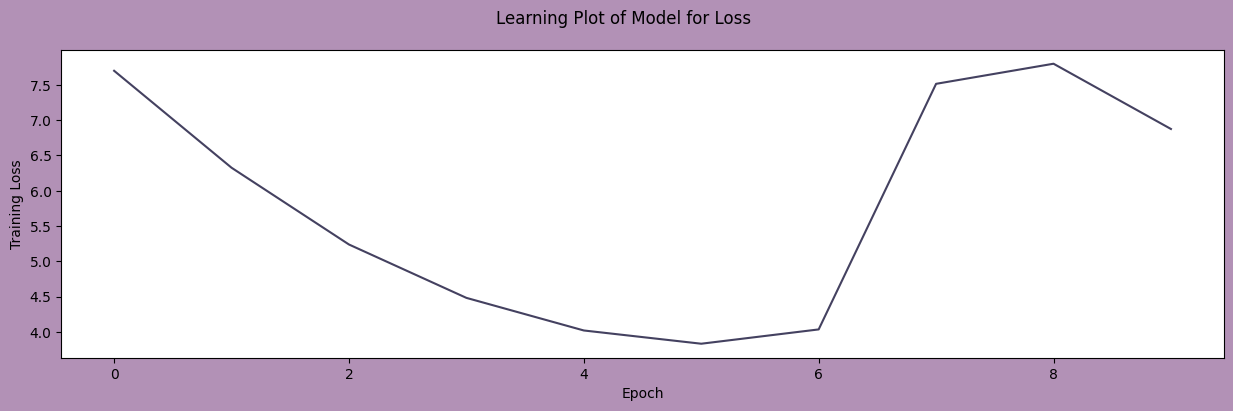

In [21]:
fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl = sns.lineplot(data=history_df["loss"], color="#444160")
pl.set(ylabel="Training Loss", xlabel="Epoch")
plt.show()

##9 Örnekleme Aşaması (NUCLEUS (TOP-p)) kullanıldı.

In [22]:
def sample_top_p(preds, temperature=0.8, top_p=0.9):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    probs = np.exp(preds)
    probs = probs / np.sum(probs)
    sorted_idx = np.argsort(probs)[::-1]
    cumulative = np.cumsum(probs[sorted_idx])
    keep = cumulative <= top_p
    idxs = sorted_idx[keep]
    if len(idxs) == 0:
        idxs = sorted_idx[:1]
    probs = probs[idxs] / probs[idxs].sum()
    return np.random.choice(idxs, p=probs)

def generate(seed_text,
             max_tokens=120,
             temperature=0.8,
             top_p=0.9):
    ids = sp.encode(seed_text, out_type=int)
    for _ in range(max_tokens):
        padded = tf.keras.preprocessing.sequence.pad_sequences(
            [ids], maxlen=SEQ_LEN, padding="pre")
        preds = model.predict(padded, verbose=0)[0]
        next_id = sample_top_p(preds, temperature, top_p)
        if next_id == sp.eos_id():
            break
        ids.append(int(next_id))
    return sp.decode(ids)


##9.Örnek üretimi **Proje GenAi kısmı sonu**


In [23]:
print("---- ÖRNEK ÇIKIŞ ----")
print(generate("Geceler kara tren", max_tokens=120, temperature=0.5, top_p=0.9))
#Başlangıç parametrelerimiz çıktı kalitesi idare eder max_tokens=120, temperature=0.8, top_p=0.9))

---- ÖRNEK ÇIKIŞ ----
Geceler kara tren uyandım gecelerde Sonra gizli Bir yanım var varken Ama bir ben bilirim Her şey insanlar Her şey bir şey var içimde bir kez daha duymam lazım Bir bakmışsın geçip gitmişsin mi söyle söyle
